In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
from pyannote.audio import Pipeline
pipeline = Pipeline.from_pretrained('pyannote/speaker-diarization-community-1')

diarization = pipeline('cocktail_party_sample.wav')

for turn, speaker in diarization.speaker_diarization:
    print(f"{speaker} speaks between t={turn.start:.4f}s and t={turn.end:.4f}s")

In [2]:
import os
from pyannoteai.sdk import Client
import librosa
import numpy as np

key_diarization = 'sk_61204b001ca5445981c96dacf5416515'

SAMPLE_RATE = 48000
CHUNK_DURATION = 2.0 # How to choose this
CHUNK_SIZE = int(SAMPLE_RATE * CHUNK_DURATION)
overlap_duration = 0.5 # min duration of overlap to run the separation

y, sr = librosa.load('cocktail_party_sample.wav', sr=SAMPLE_RATE)
audio_data = np.ascontiguousarray(y)
n_samples = len(audio_data)

client_diarization = Client(key_diarization)
job_id = client_diarization.diarize(client_diarization.upload('cocktail_party_sample.wav'))
diarization = client_diarization.retrieve(job_id)

segments = diarization['output']['diarization']
overlap_mask = np.zeros(n_samples, dtype=np.float32)
# for i, seg_i in enumerate(segments):
#     # only overlaps involving target speaker
#     if seg_i["speaker"] != 'SPEAKER_00':
#         continue

#     for j, seg_j in enumerate(segments):
#         if i!=j:
#             # intersection
#             overlap_start = max(seg_i["start"], seg_j["start"])
#             overlap_end = min(seg_i["end"], seg_j["end"])

#             if overlap_start >= overlap_end:
#                 continue  # no overlap
#             else:
#                 print("overlap detected")
#                 # time → samples
#                 start_sample = int(overlap_start * SAMPLE_RATE)
#                 end_sample = int(overlap_end * SAMPLE_RATE)
#                 print(end_sample)

#                 start_sample = max(0, start_sample)
#                 end_sample = min(n_samples, end_sample)
#                 print(f"overlap between {start_sample / SAMPLE_RATE} and {end_sample / SAMPLE_RATE}")
#                 overlap_mask[start_sample:end_sample] = 1.0
for i, seg_i in enumerate(segments):
    # 1. Filter: We only care about our Target Speaker
    if seg_i["speaker"] != 'SPEAKER_00':
        continue

    t_start = int(seg_i["start"] * SAMPLE_RATE)
    t_end = int(seg_i["end"] * SAMPLE_RATE)

    t_start = max(0, t_start)
    t_end = min(n_samples, t_end)

    overlap_mask[t_start:t_end] = 2.0

    # Check for overlaps with other speakers
    for j, seg_j in enumerate(segments):
        if i == j:
            continue

        # We only care if the OTHER segment is a different speaker
        if seg_j["speaker"] == 'SPEAKER_00':
            continue

        # Calculate Intersection
        overlap_start = max(seg_i["start"], seg_j["start"])
        overlap_end = min(seg_i["end"], seg_j["end"])

        if overlap_start >= overlap_end:
            continue

        # Convert to samples
        o_start_sample = int(overlap_start * SAMPLE_RATE)
        o_end_sample = int(overlap_end * SAMPLE_RATE)

        o_start_sample = max(0, o_start_sample)
        o_end_sample = min(n_samples, o_end_sample)

        # This takes precedence over the '2' we set earlier
        overlap_mask[o_start_sample:o_end_sample] = 1.0

/home/emiliopicard/miniconda3/envs/voice_hack/lib/python3.10/site-packages/pyannoteai/sdk/client.py:356: UserWarning: 
You are using pyannoteAI's temporary storage solution. Your file will be permanently deleted from our servers within 24hs. 
If you are running in production, we highly recommend to use your own storage to reduce network latency and obtain results faster. 
Please check our documentation at https://docs.pyannote.ai/ for more information.
  warnings.warn("""
/home/emiliopicard/miniconda3/envs/voice_hack/lib/python3.10/site-packages/pyannoteai/sdk/client.py:589: UserWarning: 
You are using periodic polling to retrieve results. 
If you are running in production, we highly recommend to setup a webhook server to obtain results faster, as soon as they are available. 
Please check our documentation at https://docs.pyannote.ai/ for more information.
  warnings.warn("""


In [47]:
import numpy as np
import librosa
SAMPLE_RATE = 48000

segments = []
y, sr = librosa.load('cocktail_party_sample.wav', sr=SAMPLE_RATE)
audio_data = np.ascontiguousarray(y)
print(len(audio_data))
n_samples = len(audio_data)
overlap_mask = np.zeros(n_samples, dtype=np.float32)
for turn, speaker in diarization.speaker_diarization:
    segments.append({
        "start": turn.start,
        "end": turn.end,
        "speaker": speaker
    })
print(segments)
# for i, seg_i in enumerate(segments):
#     # only overlaps involving target speaker
#     if seg_i["speaker"] != 'SPEAKER_00':
#         continue

#     for j, seg_j in enumerate(segments):
#         if i!=j:
#             # intersection
#             overlap_start = max(seg_i["start"], seg_j["start"])
#             overlap_end = min(seg_i["end"], seg_j["end"])

#             if overlap_start >= overlap_end:
#                 continue  # no overlap
#             else:
#                 print("overlap detected")
#                 # time → samples
#                 start_sample = int(overlap_start * SAMPLE_RATE)
#                 end_sample = int(overlap_end * SAMPLE_RATE)
#                 print(end_sample)

#                 start_sample = max(0, start_sample)
#                 end_sample = min(n_samples, end_sample)
#                 print(f"overlap between {start_sample / SAMPLE_RATE} and {end_sample / SAMPLE_RATE}")
#                 overlap_mask[start_sample:end_sample] = 1.0

for i, seg_i in enumerate(segments):
    # 1. Filter: We only care about our Target Speaker
    if seg_i["speaker"] != 'SPEAKER_00':
        continue

    t_start = int(seg_i["start"] * SAMPLE_RATE)
    t_end = int(seg_i["end"] * SAMPLE_RATE)

    t_start = max(0, t_start)
    t_end = min(n_samples, t_end)

    overlap_mask[t_start:t_end] = 2.0

    # Check for overlaps with other speakers
    for j, seg_j in enumerate(segments):
        if i == j:
            continue

        # We only care if the OTHER segment is a different speaker
        if seg_j["speaker"] == 'SPEAKER_00':
            continue

        # Calculate Intersection
        overlap_start = max(seg_i["start"], seg_j["start"])
        overlap_end = min(seg_i["end"], seg_j["end"])

        if overlap_start >= overlap_end:
            continue

        # Convert to samples
        o_start_sample = int(overlap_start * SAMPLE_RATE)
        o_end_sample = int(overlap_end * SAMPLE_RATE)

        o_start_sample = max(0, o_start_sample)
        o_end_sample = min(n_samples, o_end_sample)

        # This takes precedence over the '2' we set earlier
        overlap_mask[o_start_sample:o_end_sample] = 1.0

1440000


AttributeError: 'dict' object has no attribute 'speaker_diarization'

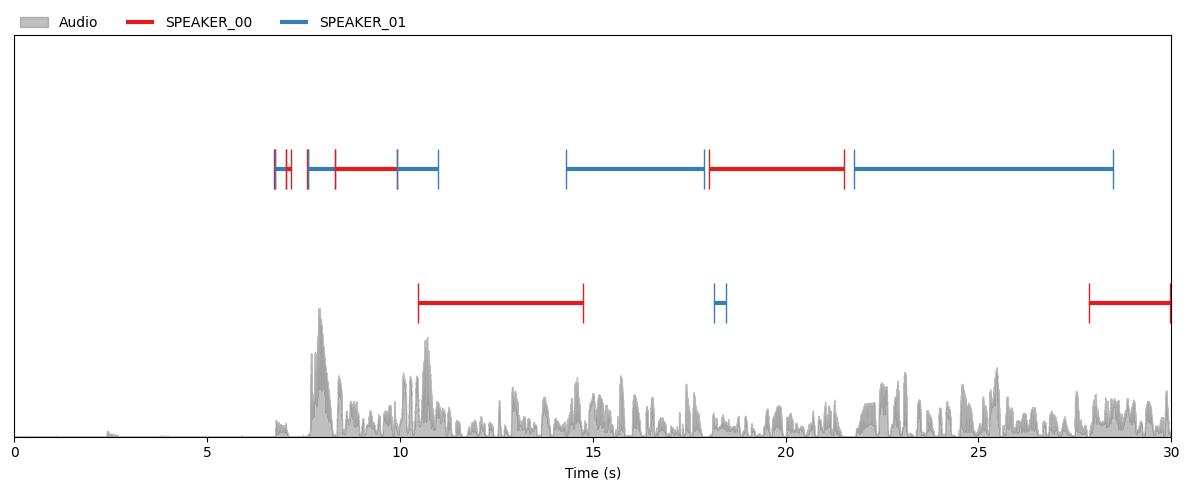

In [26]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
from pyannote.core import Segment, notebook

audio_path = 'cocktail_party_sample.wav'

annotation = diarization.speaker_diarization
y, sr = librosa.load(audio_path, sr=None)
duration = librosa.get_duration(y=y, sr=sr)
notebook.crop = Segment(0, duration)

fig, ax = plt.subplots(figsize=(12, 5))

librosa.display.waveshow(y, sr=sr, ax=ax, alpha=0.5, color="gray", label="Audio")
notebook.plot_annotation(annotation, ax=ax, time=True, legend=True)

ax.set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

Found 4!
Overlap detected from 10.5s to 11.0s
Overlap detected from 14.3s to 14.7s
Overlap detected from 18.2s to 18.4s
Overlap detected from 27.9s to 28.5s


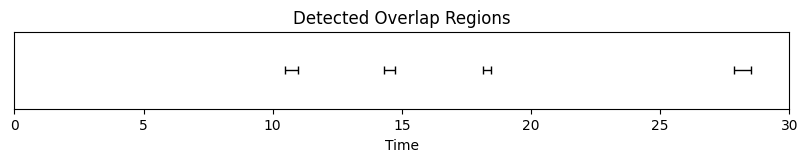

In [3]:
overlaps = annotation.get_overlap() # pyannote.core.annotation
print(f"Found {len(overlaps)}!")
for segment in overlaps:
    print(f"Overlap detected from {segment.start:.1f}s to {segment.end:.1f}s")

plt.figure(figsize=(10, 1))
notebook.plot_timeline(overlaps, time=True)
plt.title("Detected Overlap Regions")
plt.show()

In [6]:
import sounddevice as sd

for i, dev in enumerate(sd.query_devices()):
    print(i, dev['name'], "(Input channels:", dev['max_input_channels'], ")")


In [ ]:
# upload conversation file
media_url = client.upload(sample_file)

# submit a diarization job
job_id = client.voiceprint(media_url)

# retrieve diarization
diarization = client.retrieve(job_id)
diarization['output']['voiceprint'] #contains diarization output

In [51]:
import torch

In [28]:
from main import DeMixer
import librosa
TEMP_FILE = 'reference.wav'

sample_file = "mixture_audio.wav"

processor = DeMixer()
# Upload audio
media_url = processor.client.upload(TEMP_FILE)
# Submit embedding job
job_id = processor.client.voiceprint(media_url)
# Retrieve embedding
voiceprint = processor.client.retrieve(job_id)
print('voiceprint',voiceprint)
# speaker_embed variable
processor.target_speaker = voiceprint['output']['voiceprint']
y, sr = librosa.load('mixture_audio.wav', sr=48000)
final_audio, overlap_mask = processor.process_chunk(y)

Loading Pyannote Pipeline (this takes a moment)...
Pipeline ready on cpu
voiceprint {'jobId': 'a4abf4f0-a2d7-471c-884d-c3051799ff05', 'status': 'succeeded', 'createdAt': '2025-12-14T15:54:06.930Z', 'updatedAt': '2025-12-14T15:54:11.303Z', 'output': {'voiceprint': 'ALZIPoT0pz06yQq8hH04vkZPcL0H8Xq+oHLFPTxbjrwu0aq9HyEjPmgZYD57fCM+itWDPvfKN717ipg91wdsPeKPxL4Z/sQ9iHHuPrLSjj4Y8uc9ut41vxj8vTxfIzK9u7D1PlLWnj6imYC+cBeLOz1EYj2gQeE65gVcvoCzW7lzPq28+prdPYZf7j0arK08Ne29vs/A8j3UPHK+JZ5vPoyV0Dx9RKY+JwGFvpI6R71CL7W9calUPoL2gz4yNxK+kLENvnM6Mr1SzYg+jItoPVJvUD5gr5O+YpX7vvVPyT3AGOa94by8vkQObT3WQ8S9MRaxPUDumT74he69cDb1u5I39r30MoO+ITJaPsfhwT0kyBQ9CVPHPtrHOr6nBm0+vpQ4vUCjFr54gfm+7p8vPubtQb1Lroi+jVGQPM+6iz5wLVk9QJxTPhhqWzzetXw+jhuzPdj6Aj5KDcG+PbI2vmpnXTzoxIo9qI4IvK6Axr4Gb6A+rRCdPqp2TL4bSfO9Gg0LPgVZaD4wFds+U4gxPeHHob6VFqq+uhmSPNl4Vj5B4oA+1qWjvcactLwpVu0+CsxhvdY5SL5+9eM+GqexvRAAoL3bEw29oClDviVN0L145kM9UEZPvq7hmj0ZwRA/0pCWPt6BFL55OZA+uw8iPtrVIT7SKdk+uJRYPaIjtj6txM48wKSEu4hTqz6oXVi8uP67vsalhbyo+9C76xFFvvTT0Ttosyi

AxisError: axis 1 is out of bounds for array of dimension 1

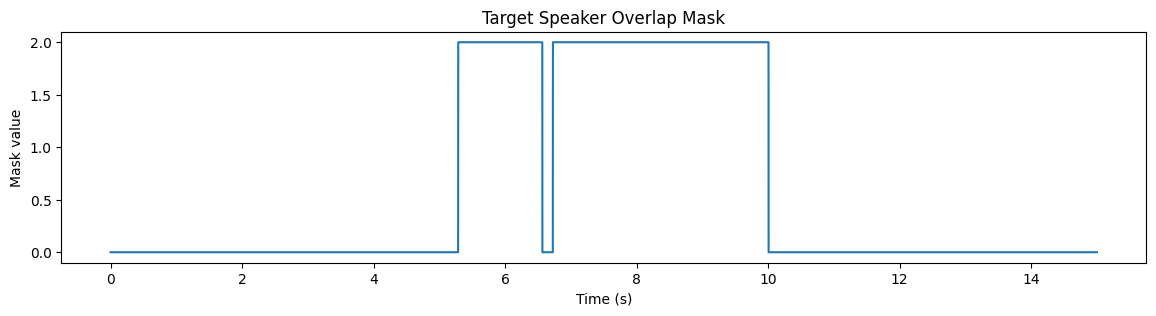

In [26]:
import matplotlib.pyplot as plt
import numpy as np
t = np.arange(len(overlap_mask)) / sr  # time axis in seconds

plt.figure(figsize=(14, 3))
plt.plot(t, overlap_mask)
plt.xlabel("Time (s)")
plt.ylabel("Mask value")
plt.title("Target Speaker Overlap Mask")
plt.ylim(-0.1, 2.1)
plt.show()

In [24]:
import IPython.display as ipd

ipd.Audio(final_audio, rate=sr)